# Proyecto final - Bootcamp LLM - CF - 2024

*Illak Zapata*

Me desvié un poquito del enunciado original pero intenté mantener la esencia de lo que se pedía y al mismo tiempo programar algo que me sea útil en mi día a día.

Tecnología utilizada:

* LLM: Gemini de Google
* LangChain 🦜🔗
* LangSmith 🦜🛠️ para debugging
* LangGraph 🦜🕸️ para construir aplicaciones *"multiagente"*

El grafo final consiste de 5 agentes (aunque en la imágen se vean 4).


![grafo_app.jpeg](grafo_app.jpeg)

## Instalamos toda la paqueteria necesaria

In [ ]:
! python -m pip install langchain
! python -m pip install --upgrade --quiet  langchain-google-genai pillow
! python -m pip install langchain_experimental
! python -m pip install -U langsmith
! python -m pip install -U langgraph
! python -m pip install httpx
! python -m pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
! python -m pip install --upgrade --quiet langchain-google-community[drive]
! python -m pip install --upgrade --quiet  nest_asyncio
! python -m pip install --upgrade --quiet unstructured
! python -m pip install -qU langchain-text-splitters

## Cargamos credenciales

El archivo `config.yml` debe tener las siguientes variables:

In [5]:
import os
import yaml

config = yaml.safe_load(open("config.yml"))

#os.environ["OPENROUTER_API_KEY"] = config["OPENROUTER_API_KEY"]
os.environ["LANGCHAIN_API_KEY"] = config["LANGCHAIN_API_KEY"]
os.environ["LANGCHAIN_TRACING_V2"] = str(config["LANGCHAIN_TRACING_V2"]).lower()
os.environ["LANGCHAIN_ENDPOINT"] = config["LANGCHAIN_ENDPOINT"]
os.environ["LANGCHAIN_PROJECT"] = config["LANGCHAIN_PROJECT"]
os.environ["LANGCHAIN_HUB_API_KEY"] = config["LANGCHAIN_API_KEY"]
os.environ["LANGCHAIN_HUB_API_URL"] = config["LANGCHAIN_HUB_API_URL"]
os.environ["GOOGLE_API_KEY"] = config["GOOGLE_API_KEY"]

GOOGLE_API_KEY = config["GOOGLE_API_KEY"]

Aunque la única clave que nos interesa para levantar el proyecto es la `GOOGLE_API_KEY`, necesaria para levantar el LLM de Google.
Otra variable de mucha utilidad es `LANGCHAIN_TRACING_V2` para debuggear usando "Langchain".

## Cargamos Modelo LLM (Gemini)

Para este proyecto se hará uso de los modelos Gemini de Google

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=4,
    google_api_key=GOOGLE_API_KEY,
    # other params...
)

Notar que podemos alternar entre lo [siguientes modelos](https://ai.google.dev/gemini-api/docs/models/gemini?hl=es-419):

- gemini-1.0-pro
- gemini-1.5-flash
- gemini-1.5-pro

Ordenados de mayor a menor cantidad de uso (capa gratuita).

## Obtenemos documentos a partir del sitemap del sitio en cuestión

In [7]:
# fixes a bug with asyncio and jupyter
import nest_asyncio

nest_asyncio.apply()

In [8]:
from langchain_community.document_loaders.sitemap import SitemapLoader

sitemap_loader = SitemapLoader(web_path="https://isep-cba.edu.ar/web/post-sitemap.xml",
                               filter_urls=["https://isep-cba.edu.ar/web/2024"], )

sitemap_loader.requests_per_second = 2
# Optional: avoid `[SSL: CERTIFICATE_VERIFY_FAILED]` issue
sitemap_loader.requests_kwargs = {"verify": False}

docs = sitemap_loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Users\ISEP\proyectos\web_RAG\.conda\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'isep-cba.edu.ar'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Fetching pages: 100%|##########| 12/12 [00:22<00:00,  1.89s/it]


Chequamos que estamos trayendo algo de contenido:

In [184]:
docs[6].page_content

'\n\n\n\n\n\n\n\n\n\n\nPrematriculaciones abiertas para las propuestas que se iniciarán en el segundo semestre de 2024 | ISEP\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPortal ISEP\n\n\nIniciar sesión\n\n\n\n\n\nFacebook\n\n\nFacebook\n\n\n\n\nYouTube\n\n\nYouTube\n\n\n\n\nInstagram\n\n\nInstagram\n\nMenúInstitucional\n\nSobre el ISEP\n\nQuiénes somos \nEquipos de trabajo \nIntegrantes del ISEP \nIFD Asociados al ISEP \nAutoridades \n\n\nProgramas institucionales\n\nNuevos lugares docentes \nEntre Lenguas \nCultura Digital \nHablar, leer y escribir \n\n\n\n\nPublicaciones\n\nRevista Scholé \nLibros\n\nColección “Pedagogía y Cultura” \n\n\nItinerarios en el tiempo \nAnuarios\n\n2022 \n2023 \n\n\n\n\nNuestras plataformas\n\nHacemos Escuela \nCanal ISEP en YouTube \n\n\nOferta académica\n\nExplorá nuestras propuestas formativas \nSobre nuestra oferta académica \nReglamento

Sólo me interesan los post de este año (2024), verifiquemos si estamos trayendo estos datos:

In [185]:
len(docs)

for doc in docs:
    print(doc.metadata['source'])

https://isep-cba.edu.ar/web/2024/07/24/el-ingles-en-la-escuela-primaria-algunas-pistas-para-pensar-juntos/
https://isep-cba.edu.ar/web/2024/07/03/ya-salio-la-edicion-n-14-de-la-revista-schole/
https://isep-cba.edu.ar/web/2024/06/14/de-coleccion-jacques-ranciere-filosoficos-de-obra-de-un-maestro-ignorante/
https://isep-cba.edu.ar/web/2024/04/15/el-isep-a-8-anos-de-su-creacion-sigue-aportando-a-la-agenda-de-la-formacion-docente-de-la-provincia/
https://isep-cba.edu.ar/web/2024/06/04/nuevos-horarios-de-atencion-en-isep-por-tareas-de-mantenimiento-edilicias/
https://isep-cba.edu.ar/web/2024/06/18/ya-podes-sumarte-al-canal-de-difusion-en-whatsapp-del-isep/
https://isep-cba.edu.ar/web/2024/05/27/prematriculaciones-abiertas-para-las-propuestas-que-iniciaran-en-el-segundo-semestre-de-2024/
https://isep-cba.edu.ar/web/2024/05/08/beatriz-greco-la-pregunta-es-como-salir-de-la-perspectiva-individualizante-e-inscribir-al-concepto-de-autoridad-y-a-su-ejercicio-en-una-perspectiva-institucional/
https

todo OK!! 👌👌

## Creamos el INDEX

Vamos a usar [FAISS](https://python.langchain.com/v0.2/docs/integrations/vectorstores/faiss/) para la BD vectorial.

In [187]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import CharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

text_splitter = CharacterTextSplitter(
    chunk_size=1200,
    chunk_overlap=500,
    length_function=len,
    is_separator_regex=False,
)
docs_split = text_splitter.split_documents(docs)

db = FAISS.from_documents(docs_split, embeddings)
print(db.index.ntotal)

retriever = db.as_retriever( search_kwargs={"k": 6} )

Created a chunk of size 2948, which is longer than the specified 1200
Created a chunk of size 1509, which is longer than the specified 1200
Created a chunk of size 1570, which is longer than the specified 1200
Created a chunk of size 1283, which is longer than the specified 1200
Created a chunk of size 1708, which is longer than the specified 1200
Created a chunk of size 2323, which is longer than the specified 1200
Created a chunk of size 2575, which is longer than the specified 1200
Created a chunk of size 1762, which is longer than the specified 1200
Created a chunk of size 1210, which is longer than the specified 1200
Created a chunk of size 5867, which is longer than the specified 1200
Created a chunk of size 3466, which is longer than the specified 1200
Created a chunk of size 3226, which is longer than the specified 1200
Created a chunk of size 1763, which is longer than the specified 1200
Created a chunk of size 1226, which is longer than the specified 1200


77


Hacemos una prueba rápida del retriever:

In [188]:
ans = retriever.invoke("¿Qué propuestas se abren para prematriculaciones en el segundo semestre?")


for a in ans:
    print(a.metadata['source'])
    print(a.page_content)

https://isep-cba.edu.ar/web/2024/05/27/prematriculaciones-abiertas-para-las-propuestas-que-iniciaran-en-el-segundo-semestre-de-2024/
Inscripciones
Contacto
Buscar


Prematriculaciones abiertas para las propuestas que se iniciarán en el segundo semestre de 2024

mayo 27, 2024Micaela Militich 

El período de inscripción comienza el 30 de mayo y permanecerá abierto hasta completar el cupo disponible en cada una de las propuestas. Conocé, en esta nota, toda la información sobre cómo concretar el proceso de prematriculación.

Desde el Instituto Superior de Estudios Pedagógicos (ISEP) informamos que se encuentra abierto el período de prematriculación para diversas propuestas formativas.
Los/las interesados/as podrán realizar el trámite de prematriculación a través de nuestro portal web: www.isep-cba.edu.ar, ingresando a la pestaña Inscripciones, o haciendo clic aquí.
Cada una de las propuestas permanecerá abierta hasta completar el cupo disponible. En ese sentido, es importante tener en cuen

Todo OK!!! 👌👌

---

## Definimos a los agentes

A continuación vamos a definir los distintos agentes que participan en el sistema. El sistema va a consistir de 5 agentes:

- Un agente que a partir de una consulta inicial, decide si debe buscar en la BD vectorial, o si debe hacer la consulta a un CSV.
- Un agente que consulta datos a un CSV.
- Un agente que corrije el formato de salida del agente anterior.
- Un agente que consulta información a una BD vectorial, con datos de posts del 2024 del [sitio web institucional](https://isep-cba.edu.ar/web/).
- Un agente que realiza RAG a partir del contexto obtenido por el agente anterior.

### Agente que consulta datos al CSV para analítica de datos

**Propósito**: Este agente va a realizar una consulta a un CSV, para esto se hace uso de la función `create_csv_agent` que devuelve un agente capaz de interactuar con un dataframe que se construye a partir de un CSV. Este agente hace uso internamente del framework `ReAct` (Reason + Act).

In [189]:
from langchain_experimental.agents.agent_toolkits import create_csv_agent
from langchain.agents.agent_types import AgentType

path_csv = "https://docs.google.com/spreadsheets/d/1DJf-7PD5pje0YXSuYezBTglg_EFQb0C88WqJEFWVpe4/export?format=csv"

csv_agent = create_csv_agent(
    llm,
    path_csv,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    allow_dangerous_code=True,
    return_intermediate_steps=True
)

In [190]:
# Define the function that calls the model
import pandas as pd

def call_csv_agent(state):
    print("---CSV AGENT---")

    question = state["question"]

    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       ):
        response = csv_agent(question)

        output = response['output']

        global intermediate_steps_glob
        intermediate_steps_glob= response['intermediate_steps']

        print(response['intermediate_steps'])
        print("//" * 30)

        """for step in response['intermediate_steps'][0]:
            intermediate_steps = intermediate_steps + step.log"""
        intermediate_steps = response['intermediate_steps'][0][0].log

    #
    return {"messages": [output], "question": question, "intermediate_steps": intermediate_steps}

### Agente que "corrige" el formato de salida de tablas principalmente

**Propósito**: Este agente tiene por objetivo "corregir" el formato de salida del agente anterior. Si el agente anterior devuelve una "tabla", este agente va a regenerar dicha tabla en formato Markdown, va a cambiar los nombres de las columnas a un formato más "amigable" y le va a agregar un título descriptivo. Además, proporciona una descripción de los pasos realizados por el agente anterior a modo de que el usuario final pueda tener una forma de "traza" de las acciones ejecutadas por el agente previo.

Gracias al mecanismo de **estado** que provee LangGraph, podemos mantener un "histórico" entre agentes, en este caso, se aprovecha para poder recuperar la trazabilidad.

In [191]:
from langchain.prompts import PromptTemplate
from langchain.agents import Agent

template = """
Eres un agente amable y especializado en cambiar el formato de salida del input
que recibe de otro primer agente analítico.

La pregunta original que responde el primer agente es: {question}\n

Debe considerar sólo una de las siguientes opciones:

1) Si la respuesta del agente analítico contiene una tabla, deberá cambiar los
nombres de las columnas por nombres que sean más "amigables" o fáciles de
entender, por ejemplo:

"linea_formativa" -> "Línea Formativa"
"anio" -> "Año"
"matricula_inicial" -> "Matrícula Inicial"
"aprobados_seminario" -> "Aprobados Seminario"
y así sucesivamente...
El nombre de la columna no debe ser muy diferentede la columna original

Si los nombres de las columnas son años, se deben dejar tal como están.
Si el nombre de la columna es un texto vacio, dejarlo como está.
Debe respetar la estructura de la tabla original.
Además debe transformar la tabla a formato markdown.
Acompañe la tabla con un título descriptivo.

2) Si la respuesta del primer agente no contiene una tabla, entonces sólo debe responder con el resultado del primer agente.
Agregue una descripción inicial de lo que se está respondiendo tomando como referencia la pregunta original.


Respuesta agente analítico:\n {input}\n

Finalmente agregue a la respuesta una explicación breve de los pasos realizados por el agente analítico a
partir de la siguiente información que debe traducir al español. Solo utilice la sección "Though" y
no sea técnico.

Pasos realizados por el agente analítico: {intermediate_steps}\n

Respuesta:\n
"""

# Define your custom prompt for the CSV agent
custom_prompt = PromptTemplate(
    input_variables=["input","question","intermediate_steps"],
    template=template
)

In [192]:
from langchain_core.output_parsers import StrOutputParser
from IPython.display import display, Markdown

agent = (
    custom_prompt
    | llm
    | StrOutputParser()
)

def call_parse_output_agent(state):
    messages = state['messages']
    question = state['question']
    documents = state['documents']
    intermediate_steps = state['intermediate_steps']

    last_message = messages[-1]
    response_csv_agent = last_message.content

    response = agent.invoke({"input": response_csv_agent, "question": question, "intermediate_steps": intermediate_steps})

    return {"messages": [response], "documents" : documents}

### Agente que consulta información a una BD Vectorial (RAG)

Propósito: El propósito de este agente (o nodo) es el de consultar a la BD vectorial, y obtener los documentos que más se asemejen (o más similares) a la consulta inicial. Luego estos documentos serán utilizados por el siguiente agente.

In [193]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]

    print(question)

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

### Agente que hace RAG

**Propósito**: Este agente utiliza los documentos obtenidos por el agente anterior como contexto para responder a la consulta inicial del usuario.

In [194]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


def answer_with_RAG(state):
    """
    Executes RAG using a set of documents as context

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key 'Message' added to the state, which contains the answer to the initial user query.
    """
    print("---ANSWER WITH RAG AGENT---")

    docs = format_docs(state["documents"])

    question = state["question"]

    prompt_template = """A partir del siguiente contexto:\n
    \n
    ```
    {context}
    ```
    \n
    Responde la pregunta del usuario de manera detallada. Si no conce la respuesta responda:\n
    "No encontré información en mi basae de conocimiento!"\n\n
    Pregunta: {question}

    """

    rag_prompt = PromptTemplate(
        input_variables=["question","context"],
        template=prompt_template
    )

    rag_chain = rag_prompt | llm | StrOutputParser()

    generation = rag_chain.invoke({"context": docs, "question": question})

    return {"messages": [generation]}


### Agente "enrutador"

**Propósito**: Es el agente inicial, encargado de decidir a partir de la pregunta del usuario si debe redirigir el trabajo hacia el agente que realiza RAG consultando una base de conocimientos con posts del sitio web de la institución, o bien, hacia el agente que consultará un CSV con datos analíticos.

In [195]:
from langchain_core.output_parsers import JsonOutputParser
from langchain.prompts import PromptTemplate


def route_question(state):
    """
    Route question to csv_agent or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")

    prompt_router = PromptTemplate(
        template="""Eres un experto redirigiendo la pregunta del usuario hacia un vectorstore o a \n
        un agente que resuelve preguntas sobre una fuente de datos (usando CSV). \n
        Use el vectorstore para preguntas relacionadas al ISEP en general, preguntas que se \n
        puedan responder usando la información provista en la página web del Instituto y \n
        que no tengan nada que ver con métricas o datos. \n
        No es necesario que sea estricto con las palabras clave de la pregunta relacionada con estos temas. \n
        Realice una decición binaria entre 'vectorstore' or 'agente_csv' en base a las preguntas. \n
        Devuelva únicamente un JSON con una unica clave 'datasource' y la decisión binaria. \n
        Pregunta a redirigir: {question}""",
        input_variables=["question"],
    )

    question_router = prompt_router | llm | JsonOutputParser()

    question = state["question"]
    #print(question)
    source = question_router.invoke({"question": question})
    print(source)
    print(source["datasource"])
    if source["datasource"] == "agente_csv":
        print("---ROUTE QUESTION TO CSV_AGENT---")
        return "agente_csv"
    elif source["datasource"] == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

## Definimos el grafo

### Definimos el estado del grafo

In [196]:
from typing import Annotated, List

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    question: str
    intermediate_steps: str
    documents: List[str]

### Construimos el grafo

In [197]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(State)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("csv_agent", call_csv_agent)  # retrieve
workflow.add_node("parse_csv_output", call_parse_output_agent)
workflow.add_node("answer_RAG", answer_with_RAG)

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "agente_csv": "csv_agent",
        "vectorstore": "retrieve",
    },
)

workflow.add_edge("csv_agent","parse_csv_output")
workflow.add_edge("retrieve","answer_RAG")

graph = workflow.compile()

### Visualizamos el grafo

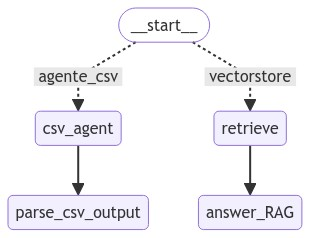

In [198]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

---

## Ponemos en marcha el multi-agente

### Consultas analíticas (sobre métricas)

In [199]:
pregunta_1 = "Necesito una tabla con cantidad de cursantes por tipo de carrera, en el año 2022"

inputs = {"question": pregunta_1}

ans = graph.invoke(inputs)


---ROUTE QUESTION---
{'datasource': 'agente_csv'}
agente_csv
---ROUTE QUESTION TO CSV_AGENT---
---CSV AGENT---


> Entering new AgentExecutor chain...
Thought: I need to group the dataframe by 'tipo' and 'anio' and then count the number of 'cursantes' for each group.
Action: python_repl_ast
Action Input: print(df.groupby(['tipo', 'anio'])['cursantes'].count())tipo                 anio
Curso                2016      4
                     2017     21
                     2018     48
                     2019     41
                     2020     65
                     2021    105
                     2022    141
                     2023    207
                     2024    182
Formación académica  2017      1
                     2018     24
                     2019     35
                     2020     37
                     2021     22
                     2022     18
                     2023      6
Postítulo            2016     23
                     2017     66
                  

In [200]:
display(Markdown(ans["messages"][-1].content))

## Cantidad de Cursantes por Tipo de Carrera en 2022

| Tipo de Carrera | Cursantes |
|---|---|
| Curso | 141 |
| Formación académica | 18 |
| Postítulo | 143 |
| Profesorado | 87 |

El agente analítico agrupó la información por tipo de carrera y año, y luego contó la cantidad de cursantes en cada grupo. 


### Consultas de información asociada al sitio web de la institución

In [201]:
pregunta_1 = "Necesito los datos de contacto del ISEP, esta información está en la web"

inputs = {"question": pregunta_1}

ans = graph.invoke(inputs)

print("\n")
print("="*60)
print("RESPUESTA FINAL:")
print("="*60)
display(Markdown(ans["messages"][-1].content))

---ROUTE QUESTION---
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE DOCUMENTS---
Necesito los datos de contacto del ISEP, esta información está en la web
---ANSWER WITH RAG AGENT---


RESPUESTA FINAL:


La información de contacto del ISEP se encuentra en la página web y es la siguiente:

* **Ubicación:** Agustín Garzón 1229, Barrio San Vicente, Córdoba, Argentina.
* **Teléfono:** 0351 – 4338615.
* **Correo electrónico:** info@isep-cba.edu.ar
* **Mesa de Ayuda:**
    * **E-mail:** mesadeayuda@isep-cba.edu.ar
    * **Teléfono:** (0351) 4 33 8615
    * **Horario de atención:** de lunes a viernes de 9 a 19 hs. 


In [202]:
pregunta_1 = "Necesito información sobre prematriculaciones en el segundo semestre del 2024, esta información está en la web"

inputs = {"question": pregunta_1}

ans = graph.invoke(inputs)

print("\n")
print("="*60)
print("RESPUESTA FINAL:")
print("="*60)
display(Markdown(ans["messages"][-1].content))

---ROUTE QUESTION---
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE DOCUMENTS---
Necesito información sobre prematriculaciones en el segundo semestre del 2024, esta información está en la web
---ANSWER WITH RAG AGENT---


RESPUESTA FINAL:


Sí, la información sobre las prematriculas para el segundo semestre de 2024 está disponible en la página web del ISEP. 

**Aquí te resumo lo que encontré:**

* **Prematriculación abierta:** El período de prematriculación para las propuestas que comienzan en el segundo semestre de 2024 ya está abierto.
* **Fecha de inicio:** El período de inscripción comienza el 30 de mayo de 2024.
* **Duración:** La prematriculación permanecerá abierta hasta completar el cupo disponible en cada propuesta.
* **Cómo prematricularse:** Puedes realizar el trámite de prematriculación a través del portal web del ISEP: www.isep-cba.edu.ar, ingresando a la pestaña "Inscripciones" o haciendo clic en el enlace que aparece en la noticia.
* **Orden de inscripción:** El proceso de prematriculación considerará el orden de inscripción, por lo que es importante realizarla lo antes posible.

**Para obtener más información sobre las propuestas formativas disponibles y cómo concretar el proceso de prematriculación, te recomiendo que visites la página web del ISEP.**


In [203]:
pregunta_1 = "Necesito información sobre el Ciclo Ciencias de la Computación en la Escuela, esta información está en la web"

inputs = {"question": pregunta_1}

ans = graph.invoke(inputs)

print("\n")
print("="*60)
print("RESPUESTA FINAL:")
print("="*60)
display(Markdown(ans["messages"][-1].content))

---ROUTE QUESTION---
{'datasource': 'vectorstore'}
vectorstore
---ROUTE QUESTION TO RAG---
---RETRIEVE DOCUMENTS---
Necesito información sobre el Ciclo Ciencias de la Computación en la Escuela, esta información está en la web
---ANSWER WITH RAG AGENT---


RESPUESTA FINAL:


El Ciclo Ciencias de la Computación en la Escuela ofrece dos seminarios:

* **"Análisis de Propuestas de Enseñanza en la Modalidad Combinada"**: Este seminario indaga las potencialidades que otorgan diferentes entornos sociotécnicos para la enseñanza, con especial atención al rol de las herramientas digitales en los distintos escenarios. Comienza en octubre de 2024.
* **"Ciencias de la Computación y su Enseñanza"**: Este seminario ofrece una introducción al campo disciplinar concreto de las Ciencias de la Computación y a algunas cuestiones fundamentales para tener en cuenta a la hora de su enseñanza. Comienza en octubre de 2024.

**Importante:** Los dos seminarios se cursan de forma consecutiva, primero "Análisis de Propuestas de Enseñanza en la Modalidad Combinada" en agosto y luego "Ciencias de la Computación y su Enseñanza" en octubre. Si deseas dar continuidad al Ciclo, debes inscribirte en ambos seminarios. 
